### Different Categories of fine tuning

The most common ways to fine-tune language models are instruction fine-tuning and
classification fine-tuning. Instruction fine-tuning involves training a language model on
a set of tasks using specific instructions to improve its ability to understand and exe-
cute tasks described in natural language prompt

In classification fine-tuning, the model is trained to recognize specefic set of class labels like whether an item is spam or not

Instruction finetuning model can undertake a wide variety of tasks whereas classification finetuning is specefic

In [33]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "spam_collection.zip"
extracted_path= "spam_collection"
data_file_path = Path(extracted_path) / "SpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if (data_file_path.exists()):
          print(f"{data_file_path} already exists therefore skipping the download")
          return
      
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read());
            
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
        
    original_file_path=Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")
    
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
    
        
  
    


spam_collection/SpamCollection.tsv already exists therefore skipping the download


In [34]:
import pandas as pd;
df = pd.read_csv(data_file_path, sep='\t', header=None, names=["Label", "Text"])
df.head(5)

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


We can see that the above dataset is not balanced since it has very few spam texts

In [36]:
import pandas as pd

def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
print(balanced_df)
print(balanced_df["Label"].value_counts())

      Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
...     ...                                                ...
5537      1  Want explicit SEX in 30 secs? Ring 02073162414...
5540      1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547      1  Had your contract mobile 11 Mnths? Latest Moto...
5566      1  REMINDER FROM O2: To get 2.50 pounds free call...
5567      1  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]
Label
0    747
1    747
Name: count, dtype: int64


Now splitting the dataset into validation, train and test

In [37]:
import pandas as pd
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [38]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Create dataloaders

We are wroking with a dataset that contains texts of varying size so we pad all messages to the lenght og the longest message in the dataset

To implement batching, where all messages are padded to the length of the lon-
gest message in the dataset, we add padding tokens to all shorter messages. For this
purpose, we use "<|endoftext|>" as a padding token. However intead of adding token directly we can use the token id corresponding to the end of text token

In [39]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


We now implement a pytorch dataset class which specefies how data is loaded and processed before the data loaders. For this purpose we define a spam dataset class which handles multiple functionalities

In [40]:

import torch
from torch.utils.data import Dataset


class SpamDataset (Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id= 50256):
        self.data = pd.read_csv(csv_file);
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length= self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]
            
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))for encoded_text in self.encoded_texts
        ]
        
    def __getitem__(self, index):
        encoded = self.encoded_texts[index];
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
            
        )
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            lenNum = len(encoded_text)
            if (lenNum > max_length):
                max_length = lenNum
                
        return max_length
        
            

In [41]:
train_dataset= SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)
print(train_dataset.max_length)

120


In [42]:
val_dataset= SpamDataset(
    csv_file="validation.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [43]:
from torch.utils.data import DataLoader

num_workers = 0;
batch_size= 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
dataset=val_dataset,
batch_size=batch_size,
num_workers=num_workers,
drop_last=False,
)
test_loader = DataLoader(
dataset=test_dataset,
batch_size=batch_size,
num_workers=num_workers,
drop_last=False,
)

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [44]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [45]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
"vocab_size": 50257,
"context_length": 1024,
"drop_rate": 0.0,
"qkv_bias": True
}
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [46]:
from gpt_download import download_and_load_gpt2
from gpt_model import GPTModel
from load_weights_into_gpt import load_weights_into_gpt
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model= GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()


File already exists and is up-to-date: gpt2/124M/checkpoint


KeyboardInterrupt: 

We now import the generate text and the mapping functions


In [ ]:
import importlib
import generate_text
importlib.reload(generate_text)
from generate_text import generate_text, token_to_text, text_to_token
text_1 = "Every effort moves you"
token_ids = generate_text(
model=model,
idx=text_to_token(text_1, tokenizer),
max_tokens=15,
context_size=BASE_CONFIG["context_length"]
)
print(token_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


### adding the classficiation head

We must modify the pretrained LLM to prepare it for classification fine-tuning. To do
so, we replace the original output layer, which maps the hidden representation to a
vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 (“not
spam”) and 1 (“spam”), as shown in figure 6.9. We use the same model as before, except
we replace the output layer.

In [ ]:
print(model)

GPTModel(
  (token_embeddings): Embedding(50257, 768)
  (position_embeddings): Embedding(1024, 768)
  (drop_embeddings): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (transformer): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForwardNetwork(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
  

We are making the output layer and the last transformer block and layer norm tunable i.e we are finetuning only these layers

In [ ]:
for param in model.parameters():
    param.requires_grad= True
    
torch.manual_seed(123)
num_classes= 2
model.output_head= torch.nn.Linear(
    in_features=BASE_CONFIG['emb_dim'],
    out_features=num_classes
)
for param in model.transformer_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Input: ", inputs)
print("Input dimensions: ", inputs.shape)


Input:  tensor([[5211,  345,  423,  640]])
Input dimensions:  torch.Size([1, 4])


In [ ]:
with torch.no_grad():
    outputs= model(inputs)
print("Outputs:\n", outputs)
print("Output dimensions: ", outputs.shape)



Outputs:
 tensor([[[-1.5840,  0.9893],
         [-3.7231,  7.4521],
         [-2.2665,  6.6035],
         [-3.5974,  3.9888]]])
Output dimensions:  torch.Size([1, 4, 2])


In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5974,  3.9888]])


 We previously computed the token ID
of the next token generated by the LLM by converting the 50,257 outputs into proba-
bilities via the softmax function and then returning the position of the highest proba-
bility via the argmax function. We take the same approach here to calculate whether
the model outputs a “spam” or “not spam” prediction for a given input

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5974,  3.9888]])


In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label: ", label.item())


Class label:  1


In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions=0
    num_examples= 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches=min(num_batches, len(data_loader))  
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch= input_batch.to(device)
            target_batch= target_batch.to(device)
            with torch.no_grad(): 
                logits= model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions+= ((predicted_labels == target_batch).sum().item())
        else:
            break
        
    return correct_predictions/ num_examples
            
    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch= target_batch.to(device)
    logits= model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
with torch.no_grad():
    train_loss = calc_loss_loader( train_loader, model, device, num_batches=5 )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss is : {train_loss:.3f}")
print(f"Validation loss is : {val_loss:.3f}")
print(f"Test loss is : {test_loss:.3f}")

Training loss is : 2.455
Validation loss is : 2.585
Test loss is : 2.324


### Finetuning the model

In [47]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, no_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs= [],[],[], []
    examples_seen, global_step= 0, -1
    for epoch in range(no_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen+= input_batch.shape[0]
            global_step += 1
            if (global_step % eval_freq == 0):
                train_loss, val_loss = evaluate_model(model ,train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "f"Train loss {train_loss:.3f}, "f"Val loss {val_loss:.3f}")
        train_accuracy= calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy=calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss= calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss=calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
            
            
    

In [49]:
import time 
start_time= time.time()
torch.manual_seed(123)
optimizer= torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs= 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(model, train_loader, val_loader, optimizer, device,no_epochs=num_epochs, eval_freq=50,eval_iter=5)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.124, Val loss 0.027
Ep 1 (Step 000050): Train loss 0.207, Val loss 0.252
Ep 1 (Step 000100): Train loss 0.014, Val loss 0.183
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training completed in 21.75 minutes.


We now plot the loss function for training and validation set

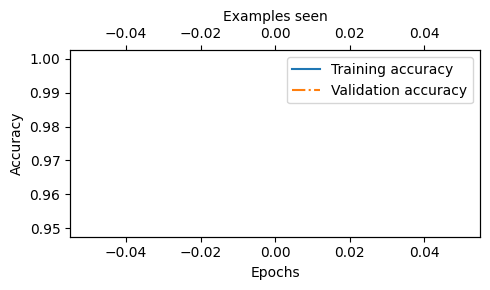

RuntimeError: linspace only supports 0-dimensional start and end tensors, but got end with 1 dimension(s).

In [ ]:
import torch
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
examples_val = examples_seen.item() if torch.is_tensor(examples_seen) else examples_seen
epochs_loss_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_loss_tensor = torch.linspace(0, examples_val, len(train_losses))
plot_values(epochs_loss_tensor, examples_loss_tensor, train_losses, val_losses, label="loss")

# 2. Plot Accuracy
epochs_acc_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_acc_tensor = torch.linspace(0, examples_val, len(train_accs))
plot_values(epochs_acc_tensor, examples_acc_tensor, train_accs, val_accs, label="accuracy")

In [ ]:
epochs_tensor= torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor= torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs,label="accuracy")



In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

### Using llm as spam classifier

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id= 50256):
    model.eval()
    input_ids= tokenizer.encode(text)
    supported_context_length= model.position_embeddings.weight.shape[1]
    input_ids= input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor= torch.tensor(input_ids, device= device).unsqueeze(0)
    with torch.no_grad():
        logits= model(input_tensor)[:, -1, :]
    predicted_label =torch.argmax(logits, dim=-1).item()
    return "spam"if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
"You are a winner you have been specially"
"selected to receive $1000 cash or a $2000 award.")
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))